In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Preprocessing (time filtering)

In [148]:
start_date = "2021-01-01"
end_date = "2021-06-30"

In [149]:
df_ori = pd.read_csv('../adyen-dataset.csv')
df_ori = df_ori.fillna("anonymous")

In [150]:
def date(row):
    year = row[3]
    day_of_year = int(row[6])
    hour_of_day = row[4]
    minute_of_hour = row[5]
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day_of_year - 1)
    return date

In [151]:
df_ori["date"] = df_ori.apply(date, axis=1)
df_ori["date"] = pd.to_datetime(df_ori["date"])

In [152]:
df_ori.set_index('date', inplace=True)
df_ts = df_ori.sort_index()

In [153]:
df_ts = df_ts.loc[start_date:end_date]

## Prepare panda edges (to feed to networkx)

In [154]:
# point_in is ip address, point_out is card number
edges1 = df_ts.groupby(["ip_address", "card_number"]).agg(total_transactions=('has_fraudulent_dispute', 'size'),
                                                          total_fraud=('has_fraudulent_dispute', 'sum')).reset_index()
edges1['type_in'] = 'ip'
edges1['type_out'] = 'card'
edges1.columns = ["point_in", "point_out", "total_transactions", "total_fraud", "type_in", "type_out"]

In [155]:
# point_in is ip address, point_out is email address
edges2 = df_ts.groupby(["ip_address", "email_address"]).agg(total_transactions=('has_fraudulent_dispute', 'size'),
                                                            total_fraud=(
                                                                'has_fraudulent_dispute', 'sum')).reset_index()
edges2['type_in'] = 'ip'
edges2['type_out'] = 'email'
edges2.columns = ["point_in", "point_out", "total_transactions", "total_fraud", "type_in", "type_out"]

In [156]:
edges3 = df_ts.groupby(["email_address", "card_number"]).agg(total_transactions=('has_fraudulent_dispute', 'size'),
                                                             total_fraud=(
                                                                 'has_fraudulent_dispute', 'sum')).reset_index()
edges3['type_in'] = 'email'
edges3['type_out'] = 'card'
edges3.columns = ["point_in", "point_out", "total_transactions", "total_fraud", "type_in", "type_out"]

In [157]:
df_edges = pd.concat([edges1, edges2, edges3], axis=0)
df_edges = df_edges[df_edges['total_transactions'] > 0]
df_edges

,point_in,point_out,total_transactions,total_fraud,type_in,type_out
0,--OIdZguyqMXZdR9uwsVaA,ueS8t6SJZdHCumx81V1lTA,2,0,ip,card
1,--Q1vMw3s-7ckmVzxYbtRA,-u5HCYQ71snACmFJ99FUKw,2,0,ip,card
2,--Q3pd2K1Id5e-7j16yGvA,wS9mv7oCTalNN5rZZ9BEww,2,0,ip,card
3,--cvU5adDKnmYHm7_gJspw,BE0HzH6gLx4ZS4K8aKkJhQ,1,0,ip,card
4,--lNkj8BIypbOtqV-mYJMw,_wGv-adF8TKJNjMdW4jlQg,1,0,ip,card
...,...,...,...,...,...,...
33753,zzZYmwCcsfozI2SMetheaQ,0ur4NOG5TJ2zAv8EADcKCg,2,0,email,card
33754,zzeiC2BlroqjXW1CHDzUFQ,ctqMeUuA4S4jIk4zWolQTw,2,0,email,card
33755,zzeiC2BlroqjXW1CHDzUFQ,iO3-A8s3Y3OyLed-c2RzCQ,1,0,email,card
33756,zznixqMdaC80Mfrz9SgxRA,0Y5dHu16ZVyLhbBRarCbSA,2,0,email,card


## Build graph

In [158]:
import networkx as nx

source = 'point_in'
target = 'point_out'

G = nx.from_pandas_edgelist(df_edges, source=source, target=target, edge_attr='total_transactions')
print(f"number of nodes {len(G.nodes)}")
print(f"number of edges {len(G.edges)}")

number of nodes 79854
number of edges 114412


Text(0, 0.5, 'Frequency')

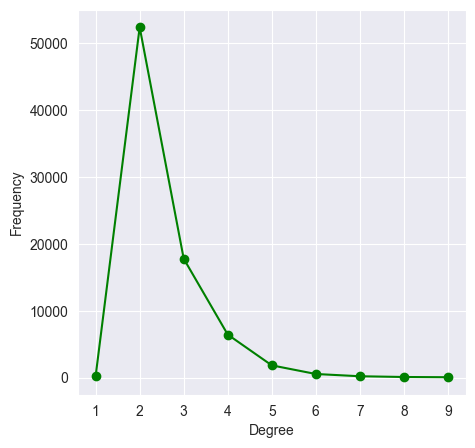

In [159]:
m = 1
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(5, 5))
plt.plot(degrees[m:10], degree_freq[m:10], 'go-')
plt.xlabel('Degree')
plt.ylabel('Frequency')

## Generate node degree feature
##### anonymous node degree replaced by 0

In [235]:
graph_features_lookup_table = pd.DataFrame(dict(
    DEGREE=dict(G.degree),
    EIGENVECTOR_CENTRALITY=nx.eigenvector_centrality_numpy(G),
    PAGE_RANK=nx.pagerank(G, alpha=0.9),
    # CLOSENESS_CENTRALITY = nx.closeness_centrality(G),
    # KATZ = nx.katz_centrality_numpy(G),
    # BETWEENNESS_CENTRALITY = nx.betweenness_centrality(G),
    # CLUSTCOEF = nx.clustering(G),
))
graph_features_lookup_table.index.name = "Node"
graph_features_lookup_table.to_csv("graph_features_lookup_table.csv", index=True)

In [225]:
df_graph_features = df_ts.loc(axis=1)["psp_reference", "ip_address", "email_address", "card_number"]
df_graph_features.reset_index(drop=True, inplace=True)

,psp_reference,ip_address,email_address,card_number
0,31441792706,qmHjXdZTQXznQZ2nK7S28A,6AIShI-nACdw5NTU_521kA,TU4KPVuB29KX7PZmtbhhUQ
1,56840734687,MoYL1fAsneKV6qc9TDsPnA,k93K-irSTKwd2pBkcXDK5w,71c2U4kmw9U_8vMaMd5YCQ
2,50841350701,yrHXrfW79VP4X1jyc7-eGw,LgvYsxCc7nbhLRujP0tYZQ,GvlEILP6lyz_nFf6bbDENg
3,81202637637,HtOkB2mBa5MG-ovenajWZg,RMJDQUiNhwzAnzCzOkUR-w,8X8Fb4r47wtQeghlxOuN0w
4,76149360397,nxVC8BgbuNyqXjZ_A8J2MQ,EGLNvgON4EdvfVMaHpn78Q,DdiFpiagUE6zrCRX6AcX0Q
...,...,...,...,...
68764,68214760093,XvudagPX0V_Z8m33ncPJBA,NTt2AEF8FObN7Rvit1Nxig,oaHHOAx8QoIw8B3pwNx7nA
68765,89916630019,anonymous,YE0SCSRBBhgLJ0Yia7cthQ,fMYqNmmIJbh6SJuadr8ikw
68766,53973861858,uynCdaWHfNcVGlNFelJFjA,nqKlCPXvQBwpfqoRCsEOlA,fN-O9cUY70fd04xi7gdlkg
68767,37252749815,mtTkY9xM79AJuthqzf6bKw,4nmbEPu1IZQOxryYB00HzA,2ygAG65z5_mE51l_sDi-sA


In [226]:
def lookup_graph_features_by_node(lookup_table, node):
    graph_features = lookup_table.loc(axis=0)[node]
    degree = graph_features["DEGREE"]
    eigen_centrality = graph_features["EIGENVECTOR_CENTRALITY"]
    page_rank = graph_features["PAGE_RANK"]
    if degree > 1000:
        degree = 0
    return degree, eigen_centrality, page_rank


def get_graph_features(row):
    ip_address = row[1]
    email_address = row[2]
    card_number = row[3]
    ip_address_features = lookup_graph_features_by_node(graph_features_lookup_table, ip_address)
    email_address_features = lookup_graph_features_by_node(graph_features_lookup_table, email_address)
    card_number_features = lookup_graph_features_by_node(graph_features_lookup_table, card_number)
    return ip_address_features, email_address_features, card_number_features

In [227]:
df_graph_features["graph_features_tuple"] = df_graph_features.apply(get_graph_features, axis=1)

In [228]:
df_graph_features[['ip_graph_features', 'email_graph_features', 'card_graph_features']] = pd.DataFrame(
    df_graph_features['graph_features_tuple'].tolist(), index=df_graph_features.index)

In [229]:
df_graph_features[['ip_node_degree', 'ip_eigen_centrality', 'ip_page_rank']] = pd.DataFrame(
    df_graph_features['ip_graph_features'].tolist(), index=df_graph_features.index)
df_graph_features[['email_node_degree', 'email_eigen_centrality', 'email_page_rank']] = pd.DataFrame(
    df_graph_features['email_graph_features'].tolist(), index=df_graph_features.index)
df_graph_features[['card_node_degree', 'card_eigen_centrality', 'card_page_rank']] = pd.DataFrame(
    df_graph_features['card_graph_features'].tolist(), index=df_graph_features.index)

In [230]:
df_graph_features.drop(
    ["ip_address", "email_address", "card_number", "graph_features_tuple", "ip_graph_features", "email_graph_features",
     "card_graph_features"], axis=1, inplace=True)

In [231]:
df_graph_features.to_csv("graph_features.csv", index=False)

In [232]:
df_graph_features

,psp_reference,ip_node_degree,ip_eigen_centrality,ip_page_rank,email_node_degree,email_eigen_centrality,email_page_rank,card_node_degree,card_eigen_centrality,card_page_rank
0,31441792706,2.0,-1.040161e-18,0.000013,2.0,-3.411500e-20,0.000013,2.0,-2.138272e-19,0.000013
1,56840734687,2.0,1.349192e-18,0.000010,3.0,1.959777e-19,0.000015,3.0,-3.473916e-19,0.000015
2,50841350701,4.0,4.281073e-03,0.000014,6.0,5.185573e-05,0.000022,4.0,4.281073e-03,0.000014
3,81202637637,2.0,8.628488e-19,0.000013,2.0,1.061320e-18,0.000013,2.0,7.523728e-19,0.000013
4,76149360397,2.0,5.153604e-05,0.000008,3.0,4.280913e-03,0.000011,3.0,4.280913e-03,0.000011
...,...,...,...,...,...,...,...,...,...,...
68764,68214760093,3.0,-1.826705e-20,0.000013,5.0,1.688328e-20,0.000020,2.0,3.082082e-19,0.000009
68765,89916630019,0.0,7.068677e-01,0.088535,3.0,4.280913e-03,0.000011,3.0,4.280913e-03,0.000011
68766,53973861858,2.0,-9.707854e-21,0.000013,2.0,-1.491765e-19,0.000013,2.0,-2.614130e-19,0.000013
68767,37252749815,2.0,1.637436e-19,0.000013,2.0,6.033042e-19,0.000013,2.0,3.747365e-19,0.000013
